# 05 - Visualización y Análisis de Resultados del Modelo

## 1. Cargar Librerías y Datos

Cargamos todas las librerías necesarias y los archivos CSV generados por el notebook 04.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

# Configuración visual de Seaborn
sns.set_theme(style="whitegrid")

# Cargar los 4 datasets generados
try:
    df_results = pd.read_csv('../data/processed/model_results.csv')
    df_metrics = pd.read_csv('../data/processed/metrics_comparison.csv')
    df_importance = pd.read_csv('../models/feature_importance.csv')
    df_map = pd.read_csv('../data/processed/avg_prices_by_location.csv')
    print("Todos los archivos de resultados fueron cargados exitosamente.")
except FileNotFoundError as e:
    print(f"Error al cargar el archivo: {e}")
    print("Por favor, asegúrate de ejecutar el notebook '04_model_comparison.ipynb' primero.")

Todos los archivos de resultados fueron cargados exitosamente.


## 2. Comparación de Métricas (Errores: RMSE y MAE)

Comparamos el RMSE y el MAE. Ambas métricas se miden en la moneda del precio (ej. USD o ARS) y nos indican el error promedio de predicción del modelo. **Valores más bajos son mejores.**

In [2]:
# Gráfico 1: Solo para RMSE y MAE (comparten la misma escala)
df_metrics_melted_errors = df_metrics.melt(id_vars='modelo', value_vars=['rmse', 'mae'], 
                                        var_name='Metrica', value_name='Valor')

fig_errors = px.bar(df_metrics_melted_errors, 
            x='modelo', 
            y='Valor', 
            color='Metrica', 
            barmode='group', 
            title='Comparación de Métricas de Error (RMSE y MAE)')
fig_errors.show()

## 3. Comparación de Métricas (Ajuste: R²)

Comparamos el R² (Coeficiente de Determinación). Esta métrica nos dice qué porcentaje de la variación del precio es explicada por nuestro modelo. **Valores más altos (cercanos a 1) son mejores.**

In [3]:
# Gráfico 2: Solo para R² (tiene su propia escala de 0 a 1)
fig_r2 = px.bar(df_metrics, 
             x='modelo', 
             y='r2', 
             color='modelo',
             title='Comparación de R² por Modelo')

# Ajustamos el rango del eje Y para que sea visible (ej. de -0.1 a 1.1)
fig_r2.update_yaxes(range=[min(-0.1, df_metrics['r2'].min() - 0.1), 1.1])
fig_r2.show()

## 4. Análisis: Real vs. Predicho

Comparamos el precio real (eje X) contra el precio predicho (eje Y). Una predicción perfecta se ubicaría sobre la línea roja diagonal. Esto nos permite ver visualmente la precisión y el sesgo de cada modelo.

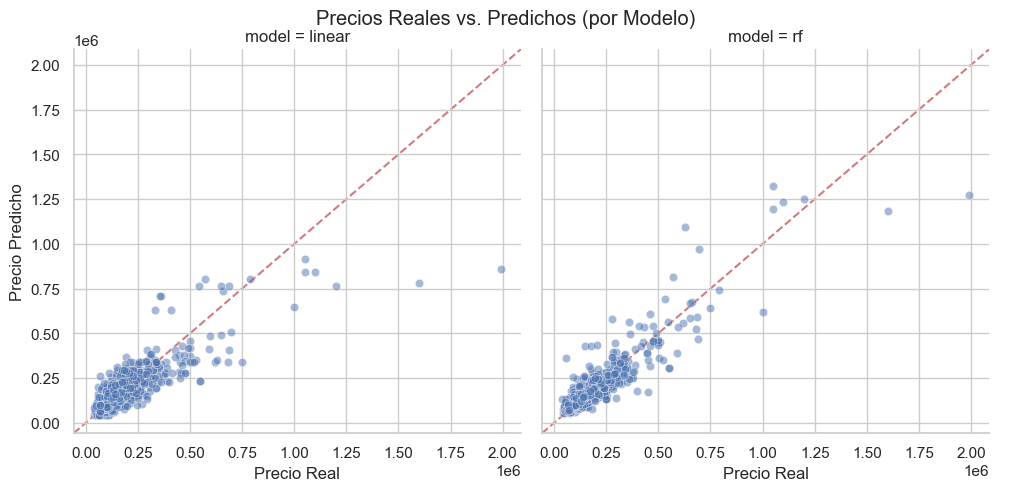

In [4]:
g = sns.FacetGrid(df_results, col="model", height=5)
g.map(sns.scatterplot, "price_real", "price_pred", alpha=0.5)
g.set_axis_labels("Precio Real", "Precio Predicho")
g.add_legend()

# Añadir la línea diagonal (predicción perfecta)
for ax in g.axes.flat:
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
    ax.set(xlim=lims, ylim=lims)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Precios Reales vs. Predichos (por Modelo)')
plt.show()

## 5. Análisis de Errores: Distribución

Este gráfico muestra la distribución de los errores (`Error = Precio Real - Precio Predicho`). En un modelo ideal, los errores se distribuirían como una campana de Gauss centrada en cero. Esto nos permite ver si el modelo tiende a sobreestimar o subestimar.

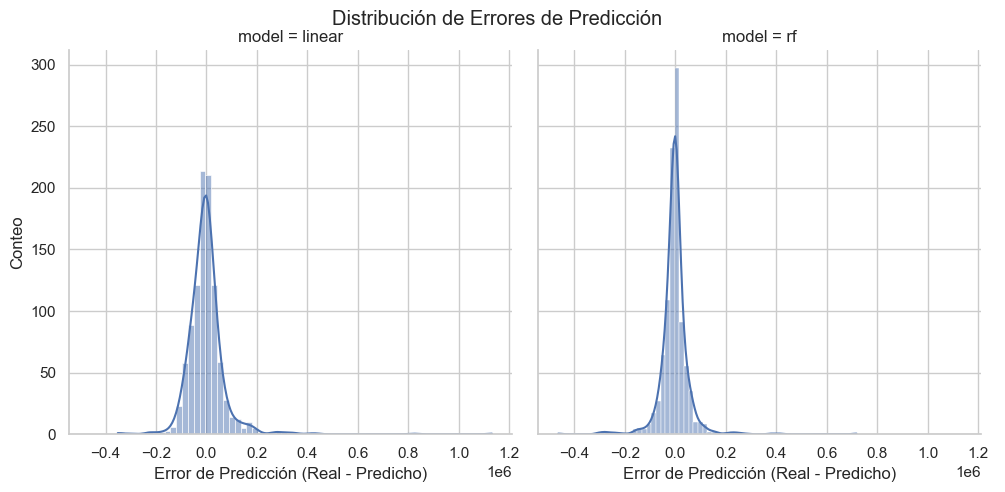

In [5]:
# Calcular el error
df_results['error'] = df_results['price_real'] - df_results['price_pred']

g = sns.FacetGrid(df_results, col="model", height=5)
g.map(sns.histplot, "error", kde=True)
g.set_axis_labels("Error de Predicción (Real - Predicho)", "Conteo")
g.add_legend()

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribución de Errores de Predicción')
plt.show()

## 6. Análisis de Errores: Gráfico de Residuos

Este gráfico es fundamental. Muestra el error (eje Y) contra el valor predicho (eje X). 

Idealmente, deberíamos ver una nube de puntos aleatoria centrada en la línea horizontal Y=0. Si vemos patrones (como un cono o una curva), significa que el modelo tiene problemas (ej. se equivoca más a medida que los precios son más altos).

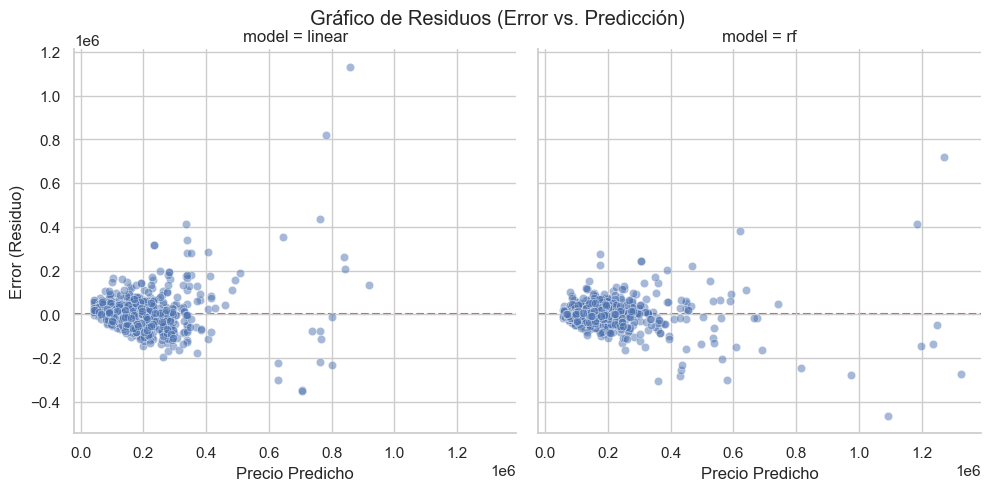

In [6]:
g = sns.FacetGrid(df_results, col="model", height=5)
g.map(sns.scatterplot, "price_pred", "error", alpha=0.5)
g.add_legend()
g.set_axis_labels("Precio Predicho", "Error (Residuo)")

# Añadir línea de error cero
for ax in g.axes.flat:
    ax.axhline(0, ls='--', c='red', alpha=0.75, zorder=0)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Gráfico de Residuos (Error vs. Predicción)')
plt.show()

## 7. Importancia de Variables (Random Forest)

Muestra qué variables (features) considera el modelo Random Forest como las más importantes para hacer una predicción. Los nombres con 'cat_' provienen de las variables categóricas (como barrios o tipo de propiedad).

<Figure size 1000x800 with 0 Axes>

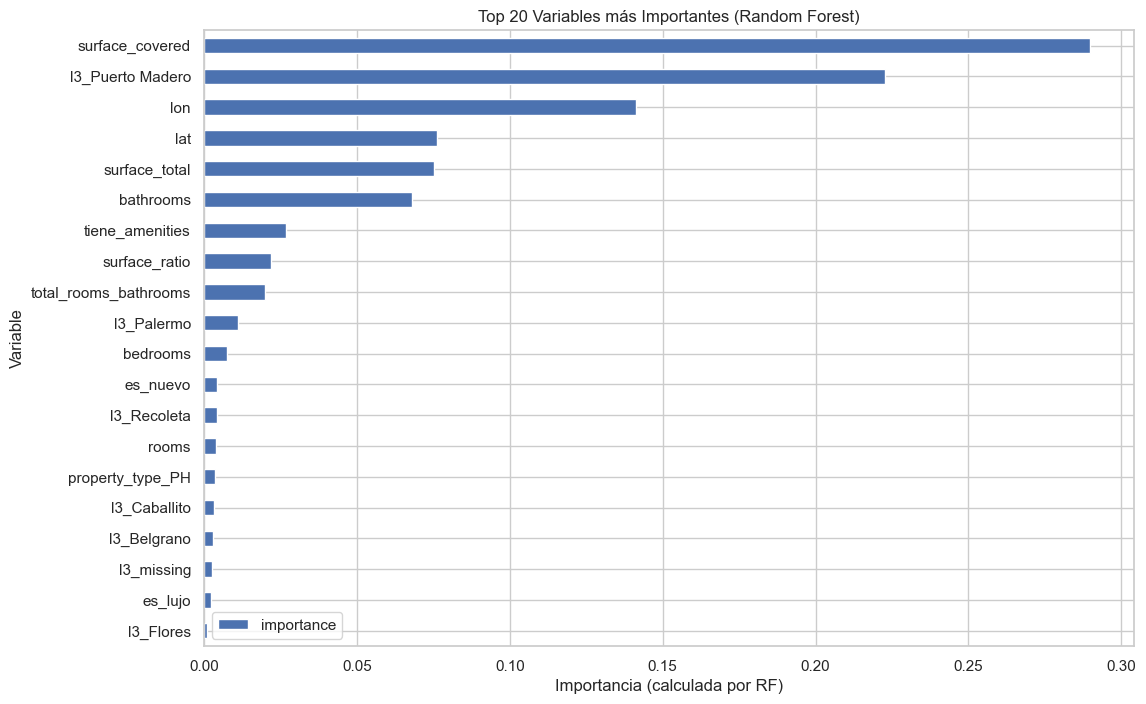

In [7]:
plt.figure(figsize=(10, 8))
# Ordenar por importancia y tomar las 20 más importantes
df_importance.sort_values(by='importance', ascending=True).tail(20).plot(
    x='feature', 
    y='importance', 
    kind='barh', 
    figsize=(12, 8), 
    title='Top 20 Variables más Importantes (Random Forest)')
plt.xlabel("Importancia (calculada por RF)")
plt.ylabel("Variable")
plt.show()

## 8. Visualización Opcional: Precios Promedio por Ubicación

In [8]:
# Asegurarse de que las columnas sean string
df_map['neighborhood'] = df_map['neighborhood'].astype(str)

# Graficar solo las 50 ubicaciones con precios promedio más altos para claridad
df_map_top50 = df_map.sort_values(by='avg_price', ascending=False).head(50)

fig = px.scatter(
    df_map_top50,
    x='neighborhood',
    y='avg_price',        
    size='avg_price',     
    color='avg_price',    
    hover_name='neighborhood',
    title='Precio Promedio por Barrio (Top 50 más caros)',
    labels={'neighborhood':'Barrio', 'avg_price':'Precio Promedio'}
)

fig.update_layout(
    xaxis_title='Barrio',
    yaxis_title='Precio Promedio',
    xaxis={'tickangle': -45}
)

fig.show()